                                        Big Data Job Analyst

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Load dataset
df = pd.read_csv('DataAnalyst.csv')
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [18]:
# Display basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
Unnamed: 0           2253 non-null int64
Job Title            2253 non-null object
Salary Estimate      2253 non-null object
Job Description      2253 non-null object
Rating               2253 non-null float64
Company Name         2252 non-null object
Location             2253 non-null object
Headquarters         2253 non-null object
Size                 2253 non-null object
Founded              2253 non-null int64
Type of ownership    2253 non-null object
Industry             2253 non-null object
Sector               2253 non-null object
Revenue              2253 non-null object
Competitors          2253 non-null object
Easy Apply           2253 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 281.8+ KB
None
   Unnamed: 0                                          Job Title  \
0           0  Data Analyst, Center on Immigration and Justic...   
1           1   

In [19]:
# Remove rows where the target variable is NaN
df.dropna(subset=[df.columns[-1]], inplace=True)

In [20]:
# Separate features and target variable
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Map target labels to {0, 1} if necessary
if y.dtype == 'object':
    y = y.astype(str).map({'-1': 0, 'True': 1, 'False': 0})

In [22]:
# Check for any remaining NaN values in y
y.fillna(y.mode()[0], inplace=True)
print("Unique values in target after processing:", y.unique())

Unique values in target after processing: [1 0]


In [23]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [24]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [25]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Convert to dense array
])

In [26]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [27]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [29]:
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.2f}\n")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.show()


Logistic Regression Accuracy: 0.97

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       657
           1       1.00      0.11      0.19        19

    accuracy                           0.97       676
   macro avg       0.99      0.55      0.59       676
weighted avg       0.98      0.97      0.96       676



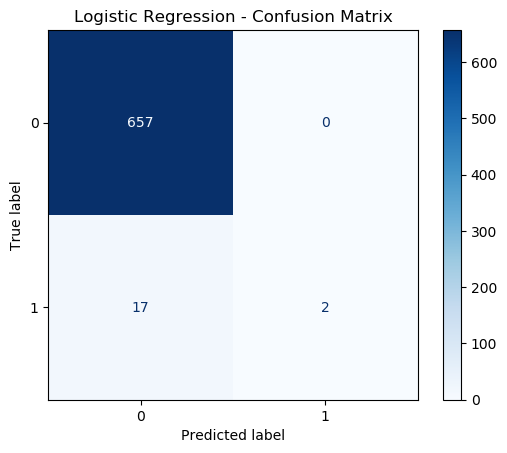

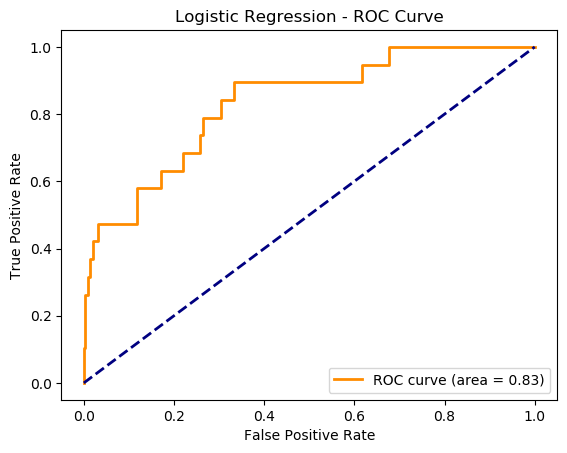

In [ ]:
for name, model in classifiers.items():
    evaluate_classifier(name, model, X_train, X_test, y_train, y_test)

rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_clf.fit(X_train, y_train)
rf_model = rf_clf.named_steps['classifier']

if hasattr(rf_model, 'feature_importances_'):
    feature_importances = rf_model.feature_importances_
    feature_names = numerical_cols.tolist() + \
                    rf_clf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
    feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_importances.head(10))
    plt.title('Top 10 Feature Importances - Random Forest')
    plt.show()